In [2]:
from src_old.memory_game.game import Game
from src_old.strategy.strategies import BaseStrategy, PerfectMemory, TileMemory, RandomHashMemory, BaseAttractorMemory, CNNAttractorMemory, RandomAttractorMemory, BernoulliMemory, BinaryAttractorMemory, FastAttractorMemory
from src_old.models.cvmodel import CVModel
from src_old.models.memory import TileRNN, HashRNN, FastAttractor

from fiftyone import ViewField as F

import math

import torch

import pandas as pd

import numpy as np

import collections, gc, resource

from tqdm import tqdm

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
sns.set_style(style='white')        

torch.no_grad()

# TODOS
* Collect data on random vs non random perfect memory (easy)

In [3]:
print(f'Cuda available: {torch.cuda.is_available()}')
print(f'Cuda device count: {torch.cuda.device_count()}')

Cuda available: True
Cuda device count: 4


In [4]:
device = 1

device = torch.device(f"cuda:{device}")
print(torch.cuda.get_device_name(device))

GeForce RTX 2080 Ti


# Global

In [6]:
n_trials = 20

size_range = [[3,3], [4,4], [5,5], [6,6], [7,7]]

steps = 10

# Functions

In [7]:
def play_strategy(strategy, game):
    win = False
    while not win:
        strategy.pick()
        win, tot = game.check_win()
        torch.cuda.empty_cache()
    return tot

In [8]:
def collect_data(n_trials, size_range, strategy, game):
    data = []
    for size in size_range:
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size)
            strategy.reset()
            tot = play_strategy(strategy, game)
            tot = math.log10(tot/np.prod(size))
            nlsc_m, nlsc_mm = game.get_number_since_last_click()
            data.append({'run': n, 'size': str(size[0]), 'nc': tot, 'nlsc_m': nlsc_m, 'nlsc_mm': nlsc_mm})
    return pd.DataFrame(data)

In [9]:
def collect_data_attractor(n_trials, size_range, game, lr, rr, familiar=False):
    data = []
    for size in size_range:
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size)
            dim = np.prod(size) + len(np.unique(game.get_grid_labels()))
            # dim = 74
            memory = FastAttractor(dim, lr, rr)
            strategy = FastAttractorMemory(game, memory, np.prod(size), familiar=familiar, steps=10)
            tot = play_strategy(strategy, game)
            tot = math.log10(tot/np.prod(size))
            nlsc_m, nlsc_mm = game.get_number_since_last_click()
            nlsp_m, nlsp_mm = game.get_number_since_last_pair()
            data.append({'run': n, 'size': str(size[0]), 'nc': tot, 'nlsc_m': nlsc_m, 'nlsc_mm': nlsc_mm, 'nlsp_m': nlsp_m, 'nlsp_mm': nlsp_mm})
    return pd.DataFrame(data)

In [10]:
def plot_history(locations, category):
    # create a 3 X 2 grid 
    fig = plt.figure(figsize=(24, 10))
    gs = grd.GridSpec(3, 2, figure=fig, height_ratios=[len(locations),len(locations),len(category)], width_ratios=[18,1], wspace=0.4)
    # image plot
    ax1 = plt.subplot(gs[1,0])
    p1 = ax1.imshow(locations, aspect='auto', interpolation='none', cmap='hot')
    colorAx1 = plt.subplot(gs[1,1])
    cb1 = plt.colorbar(p1, cax = colorAx1)
    # image plot
    ax2 = plt.subplot(gs[2,0])
    p2 = ax2.imshow(category, aspect='auto', interpolation='none', cmap='hot')
    colorAx2 = plt.subplot(gs[2,1])
    cb2 = plt.colorbar(p2, cax = colorAx2)
    
    plt.show()

# Collect data

In [17]:
game = Game(
            dataset_name='coco-2017', 
            split='validation', 
            field="ground_truth", 
            ds_filter=F("supercategory").is_in(('person', 'animal', 'food', 'vehicle', 'indoor')),
            dataset_dir ="/home/ravi/datasets/coco-2017",
            seed = 42
        )

Found annotations at '/home/ravi/datasets/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [10]:
bs = BaseStrategy(game)
bs_df = collect_data(n_trials, size_range, bs, game)
bs_df['strategy'] = 'Random memory'


Size: [7, 7]: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


In [11]:
pm = PerfectMemory(game)
pm_df = collect_data(n_trials, size_range, pm, game)
pm_df['strategy'] = 'Perfect memory'


Size: [7, 7]: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


In [18]:
att_df = collect_data_attractor(n_trials, size_range, game, lr=0.29, rr=0.995, familiar=False)
att_df['strategy'] = 'Attractor'

Size: [3, 3]:   0%|          | 0/20 [00:02<?, ?it/s]


KeyboardInterrupt: 

# Plots

In [ ]:
data = pd.concat([bs_df, pm_df, att_df])

<Figure size 800x1600 with 0 Axes>

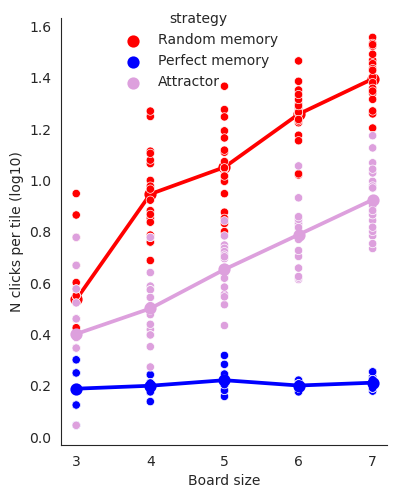

In [ ]:
plt.figure(figsize=(8, 16))
palette = ['red', 'blue', 'plum']
ax2 = sns.catplot(x="size", y='nc', hue="strategy", data=data, aspect=0.85, errorbar=None, kind='point', palette=palette)
ax = sns.scatterplot(x="size", y='nc', hue="strategy", data=data, legend=False, palette=palette)
ax.set_xlabel("Board size")
ax.set_ylabel("N clicks per tile (log10)")
sns.move_legend(ax2, "upper center")
#plt.savefig('/home/ravi/figures/attractor.svg')

In [ ]:
df = pd.melt(att_df, var_name="trial", value_name="nslc", id_vars=['size', 'strategy', 'nc', 'run'])

<Figure size 800x1600 with 0 Axes>

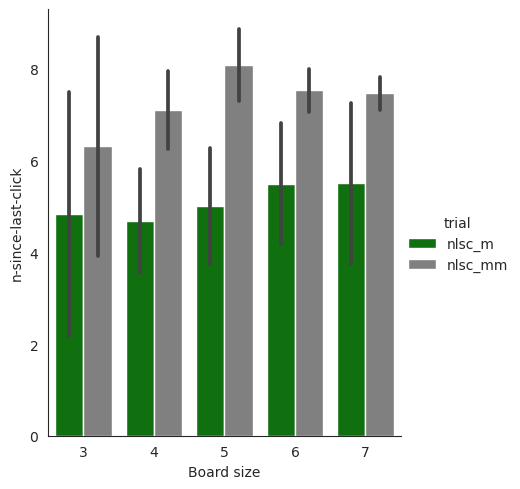

In [ ]:
plt.figure(figsize=(8, 16))
palette = ['green', 'grey']
# Draw a nested barplot by species and sex
ax = sns.catplot(x="size", y="nslc", hue='trial', data=df[df['trial'].isin(['nlsc_m', 'nlsc_mm'])], aspect=0.85, errorbar="sd", kind='bar', palette=palette)
ax.set(xlabel="Board size", ylabel="n-since-last-click")
plt.show()

<Figure size 800x1600 with 0 Axes>

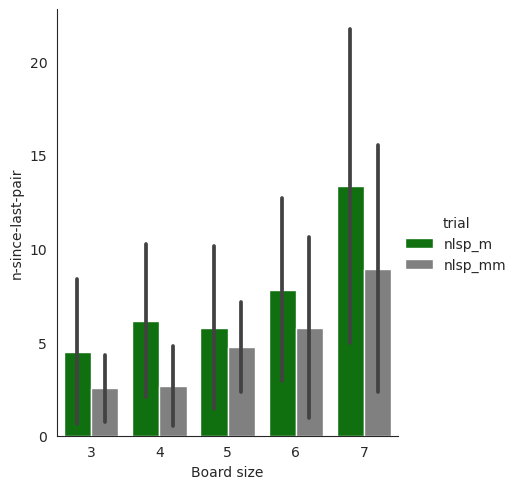

In [ ]:
plt.figure(figsize=(8, 16))
df = pd.melt(att_df, var_name="trial", value_name="nslp", id_vars=['size', 'strategy', 'nc', 'run'])
palette = ['green', 'grey']
# Draw a nested barplot by species and sex
ax = sns.catplot(x="size", y="nslp", hue='trial', data=df[df['trial'].isin(['nlsp_m', 'nlsp_mm'])], aspect=0.85, errorbar="sd", kind='bar', palette=palette)
ax.set(xlabel="Board size", ylabel="n-since-last-pair")
plt.show()

[2 3 2 4 0 3 0 1 4]
[0 1 2 3 4 5 6 7 8]
16


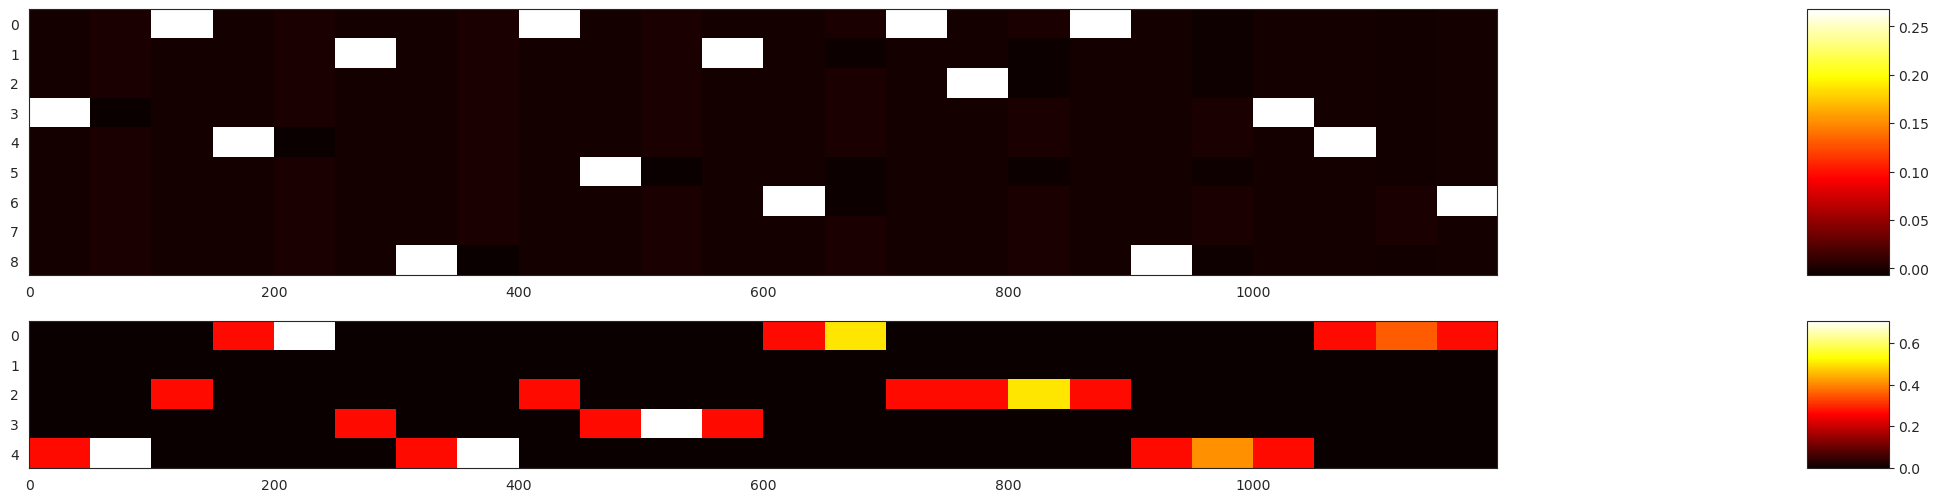

In [ ]:
size = [3,3]
game.set_size(size)
pos_f = np.prod(size)
lab_f = len(np.unique(game.get_grid_labels()))
dim = pos_f + lab_f
memory = FastAttractor(dim, lr=0.349, rr=0.995)
strategy = FastAttractorMemory(game, memory, np.prod(size), familiar=False, steps=10)
print(game.get_grid_labels())
print(np.arange(9))
tot = play_strategy(strategy, game)
print(tot)
ah = memory.get_activation_history()
plot_history(ah[:, :pos_f].T, ah[:, pos_f:].T)